# MODELING NOTEBOOK

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, re
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC 
from sklearn.ensemble import GradientBoostingClassifier

from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('df.csv')
df.head()

,patient_id,last.status,is_icu,length_of_stay,days_prior_sx,8331-1_Oral temperature,59408-5_Oxygen saturation in Arterial blood by Pulse oximetry,9279-1_Respiratory rate,76282-3_Heart rate.beat-to-beat by EKG,8480-6_Systolic blood pressure,...,x7_False,x7_True,x8_False,x8_True,x9_False,x9_True,x10_False,x10_True,x11_False,x11_True
0,A917122,discharged,0.0,9.0,10.6,36.4,91.0,22.0,86.0,172.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,A387558,deceased,1.0,15.0,4.2,37.0,100.0,39.0,149.0,158.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
2,A968238,deceased,1.0,28.0,4.0,37.4,84.0,42.0,88.0,130.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,A106133,deceased,0.0,4.0,6.0,36.7,96.0,16.0,100.0,132.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,A300871,deceased,0.0,3.0,6.0,36.7,97.0,20.0,94.0,104.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [3]:
X = df.drop(labels=['last.status'], axis=1)
mapping = {'discharged':1, 'deceased':0}
y = df['last.status'].replace(mapping)

In [4]:
df['last.status'].value_counts()

discharged    1178
deceased       135
Name: last.status, dtype: int64

In [5]:
X.set_index('patient_id', inplace=True)
X.head()

,is_icu,length_of_stay,days_prior_sx,8331-1_Oral temperature,59408-5_Oxygen saturation in Arterial blood by Pulse oximetry,9279-1_Respiratory rate,76282-3_Heart rate.beat-to-beat by EKG,8480-6_Systolic blood pressure,76536-2_Mean blood pressure by Noninvasive,33256-9_Leukocytes [#/volume] corrected for nucleated erythrocytes in Blood by Automated count,...,x7_False,x7_True,x8_False,x8_True,x9_False,x9_True,x10_False,x10_True,x11_False,x11_True
patient_id,,,,,,,,,,,,,,,,,,,,,
A917122,0.0,9.0,10.6,36.4,91.0,22.0,86.0,172.0,91.0,9.380,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
A387558,1.0,15.0,4.2,37.0,100.0,39.0,149.0,158.0,109.0,25.190,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
A968238,1.0,28.0,4.0,37.4,84.0,42.0,88.0,130.0,93.0,9.110,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
A106133,0.0,4.0,6.0,36.7,96.0,16.0,100.0,132.0,71.0,6.060,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
A300871,0.0,3.0,6.0,36.7,97.0,20.0,94.0,104.0,99.0,5.808,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [6]:
X.columns

Index(['is_icu', 'length_of_stay', 'days_prior_sx', '8331-1_Oral temperature',
       '59408-5_Oxygen saturation in Arterial blood by Pulse oximetry',
       '9279-1_Respiratory rate', '76282-3_Heart rate.beat-to-beat by EKG',
       '8480-6_Systolic blood pressure',
       '76536-2_Mean blood pressure by Noninvasive',
       '33256-9_Leukocytes [#/volume] corrected for nucleated erythrocytes in Blood by Automated count',
       '751-8_Neutrophils [#/volume] in Blood by Automated count',
       '731-0_Lymphocytes [#/volume] in Blood by Automated count',
       '2951-2_Sodium [Moles/volume] in Serum or Plasma',
       '1920-8_Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma',
       '1744-2_Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma by No addition of P-5'-P',
       '2524-7_Lactate [Moles/volume] in Serum or Plasma',
       '6598-7_Troponin T.cardiac [Mass/volume] in Serum or Plasma',
       '33762-6_Natriuretic peptide.B prohormone 

In [7]:
#rename alaine col to remove ', causes error in scaling algo
X.columns[14]

"1744-2_Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma by No addition of P-5'-P"

In [8]:
X.rename(columns={X.columns[14]: "1744-2_Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma by No addition of P-5-P"}, 
         inplace=True)

In [9]:
#rename check
X.columns

Index(['is_icu', 'length_of_stay', 'days_prior_sx', '8331-1_Oral temperature',
       '59408-5_Oxygen saturation in Arterial blood by Pulse oximetry',
       '9279-1_Respiratory rate', '76282-3_Heart rate.beat-to-beat by EKG',
       '8480-6_Systolic blood pressure',
       '76536-2_Mean blood pressure by Noninvasive',
       '33256-9_Leukocytes [#/volume] corrected for nucleated erythrocytes in Blood by Automated count',
       '751-8_Neutrophils [#/volume] in Blood by Automated count',
       '731-0_Lymphocytes [#/volume] in Blood by Automated count',
       '2951-2_Sodium [Moles/volume] in Serum or Plasma',
       '1920-8_Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma',
       '1744-2_Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma by No addition of P-5-P',
       '2524-7_Lactate [Moles/volume] in Serum or Plasma',
       '6598-7_Troponin T.cardiac [Mass/volume] in Serum or Plasma',
       '33762-6_Natriuretic peptide.B prohormone N

In [10]:
# to_scale = ['is_icu', 'length_of_stay', 'days_prior_sx', '8331-1_Oral temperature',
#        '59408-5_Oxygen saturation in Arterial blood by Pulse oximetry',
#        '9279-1_Respiratory rate', '76282-3_Heart rate.beat-to-beat by EKG',
#        '8480-6_Systolic blood pressure',
#        '76536-2_Mean blood pressure by Noninvasive',
#        '33256-9_Leukocytes [#/volume] corrected for nucleated erythrocytes in Blood by Automated count',
#        '751-8_Neutrophils [#/volume] in Blood by Automated count',
#        '731-0_Lymphocytes [#/volume] in Blood by Automated count',
#        '2951-2_Sodium [Moles/volume] in Serum or Plasma',
#        '1920-8_Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma',
#        '1744-2_Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma by No addition of P-5-P',
#        '2524-7_Lactate [Moles/volume] in Serum or Plasma',
#        '6598-7_Troponin T.cardiac [Mass/volume] in Serum or Plasma',
#        '33762-6_Natriuretic peptide.B prohormone N-Terminal [Mass/volume] in Serum or Plasma',
#        '75241-0_Procalcitonin [Mass/volume] in Serum or Plasma by Immunoassay',
#        '48058-2_Fibrin D-dimer DDU [Mass/volume] in Platelet poor plasma by Immunoassay',
#        '2276-4_Ferritin [Mass/volume] in Serum or Plasma',
#        '1988-5_C reactive protein [Mass/volume] in Serum or Plasma',
#        '39156-5_Body mass index (BMI) [Ratio]',
#        '2951-2_Sodium [Moles/volume] in Serum or Plasma.1',
#        '2823-3_Potassium [Moles/volume] in Serum or Plasma',
#        '2075-0_Chloride [Moles/volume] in Serum or Plasma',
#        '1963-8_Bicarbonate [Moles/volume] in Serum or Plasma',
#        '3094-0_Urea nitrogen [Mass/volume] in Serum or Plasma',
#        '2160-0_Creatinine [Mass/volume] in Serum or Plasma',
#        '62238-1_Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum, Plasma or Blood by Creatinine-based formula (CKD-EPI)',
#        '2345-7_Glucose [Mass/volume] in Serum or Plasma',]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [12]:
#attempt to scale the data w/ standardscaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
X_train_scaled

array([[-0.44143042, -0.70353762,  0.491281  , ..., -0.73871941,
         0.63404262, -0.63404262],
       [-0.44143042, -0.53560949,  0.0302403 , ...,  1.35369395,
         0.63404262, -0.63404262],
       [-0.44143042,  0.22006711,  2.33544379, ..., -0.73871941,
         0.63404262, -0.63404262],
       ...,
       [-0.44143042, -0.70353762,  0.72180135, ...,  1.35369395,
         0.63404262, -0.63404262],
       [-0.44143042,  0.72385151,  0.0302403 , ..., -0.73871941,
        -1.57718103,  1.57718103],
       [-0.44143042, -0.70353762, -0.06196784, ...,  1.35369395,
         0.63404262, -0.63404262]])

### Dummy classifier baseline model

In [14]:
#creation of baseline model with dummy classifier



dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_scaled, y_train)
dummy.score(X_test_scaled, y_test)

0.9137055837563451

### Functions for plots and metrics

In [15]:
def metrics_crossval_score(model, X_train, X_test, y_train, y_test, y_pred):
    train = cross_val_score(model, X_train, y_train, cv=5).mean()
    test = cross_val_score(model, X_test, y_test, cv=5).mean()
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    return ("Training set score:", train), ("Test set score:", test), ('Accuracy:', acc), ('F1 score:', f1), ('Precision:', prec)



In [1]:
def plot_matrix(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred)
    
    return sns.heatmap(matrix, annot=True, cmap='BuPu', fmt='.4g', xticklabels=['Deceased', 'Discharged'], 
                       yticklabels=['Deceased', 'Discharged']), plt.yticks(rotation=0)

## LOGISTIC REGRESSION MODEL

In [17]:
#create logistic regression model, fit to training data and score on test data

lr = LogisticRegression(random_state=42, max_iter=10000)
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)
lr.score(X_test_scaled, y_test)

0.9238578680203046

<AxesSubplot:>

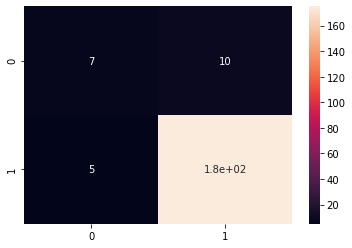

In [18]:
#confusion matrix of lr model
plot_matrix(y_test, y_pred);


In [19]:
y_test.value_counts()

1    180
0     17
Name: last.status, dtype: int64

### Insight: There is a class imbalance in the target. The test size will be increased, and will use various resampling techniques to address the imbalance (SMOTE, etc). We can also use XGBoost as another algorithm to for classification.

**Can GridSearchCV improve modeling scores??**

In [20]:
# #Optimized grid search parameters are used in the lr2 model, so this section is commented to decrease processing time

# param_grid = {'penalty':['l2', 'l1','elasticnet'],
#              'max_iter':[1000, 10000, 100000]}

# Grid = GridSearchCV(estimator=lr, param_grid=param_grid)
# Grid.fit(X_train, y_train)

In [21]:
# Grid.best_params_

#### GridSearchCV concludes that initial conditions were best. Will use Cross validation to determine model performance

In [22]:
print(cross_val_score(lr, X_train_scaled, y_train, cv=5).mean())
print(cross_val_score(lr, X_test_scaled, y_test, cv=5).mean())

0.9328034913516976
0.8883333333333333


**Insight: the model is overfit. This verifies the data must be resampled. Will adjust the test size and resample if necessary**

In [23]:
# will increasing the test size improve the model and help overfitting?

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.30, random_state=42)

scaler2 = StandardScaler().fit(X_train2)
X_train2_scaled = scaler2.transform(X_train2)
X_test2_scaled = scaler2.transform(X_test2)

lr2 = LogisticRegression(random_state=42, max_iter=1000)
lr2.fit(X_train2_scaled, y_train2)
y_pred2 = lr2.predict(X_test2_scaled)
lr2.score(X_test2_scaled, y_test2)

0.9263959390862944

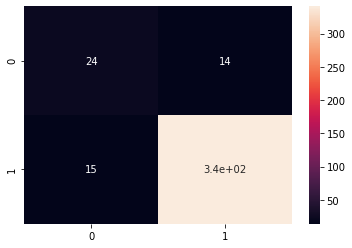

In [24]:
cf_matrix2 = confusion_matrix(y_test2, y_pred2)
sns.heatmap(cf_matrix2, annot=True);

In [25]:
print(cross_val_score(lr2, X_train2_scaled, y_train2, cv=5).mean())
print(cross_val_score(lr2, X_test2_scaled, y_test2, cv=5).mean())

0.9325492991209314
0.8985069782538139


In [26]:
y_test2.value_counts()

1    356
0     38
Name: last.status, dtype: int64

### Insight: increasing the test size improves model performance, but the model still doesn't predict well. Will oversample the minority class (deceased/0) and re-evaluate the model.

<AxesSubplot:>

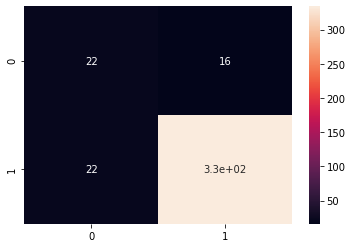

In [27]:
#try: SMOTE, penalized-SVM



svc = SVC(class_weight='balanced', probability=True)
svc.fit(X_train2_scaled, y_train2)
svc_pred = svc.predict(X_test2_scaled)
plot_matrix(y_test2, svc_pred);

In [28]:
metrics_crossval_score(svc, X_train2_scaled, X_test2_scaled, y_train2, y_test2, svc_pred)

(('Training set score:', 0.9140472796388691),
 ('Test set score:', 0.8909120415449531),
 ('Accuracy:', 0.9035532994923858),
 ('F1 score:', 0.9461756373937678),
 ('Precision:', 0.9542857142857143))

In [29]:
#SMOTE of target variable

import imblearn
from imblearn.over_sampling import SMOTE

smote=SMOTE()

x_train_smote, y_train_smote = smote.fit_resample(X_train2_scaled, y_train2)

print('Original dataset shape', y_train2.value_counts())
print('Resample dataset shape', y_train_smote.value_counts())

Original dataset shape 1    822
0     97
Name: last.status, dtype: int64
Resample dataset shape 1    822
0    822
Name: last.status, dtype: int64


<AxesSubplot:>

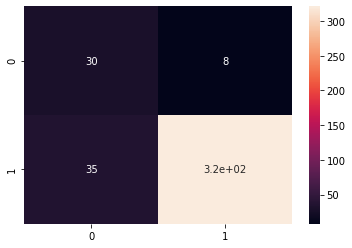

In [30]:
#logreg model with smote variables

lr3 = LogisticRegression(random_state=42, max_iter=10000)
lr3.fit(x_train_smote, y_train_smote)
lr3_pred = lr3.predict(X_test2_scaled)
plot_matrix(y_test2, lr3_pred);

In [31]:
metrics_crossval_score(lr3, x_train_smote, X_test2_scaled, y_train_smote, y_test2, lr3_pred)

(('Training set score:', 0.939797242197346),
 ('Test set score:', 0.8985069782538139),
 ('Accuracy:', 0.8908629441624365),
 ('F1 score:', 0.9372262773722628),
 ('Precision:', 0.9756838905775076))

#### Can KNN do a better job at prediction?

## K Nearest Neighbors Classifier modeling

In [32]:
#KNN attempt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train2_scaled, y_train2)
y_pred_knn = knn.predict(X_test2_scaled)
knn.score(X_test2_scaled, y_test2)

0.9111675126903553

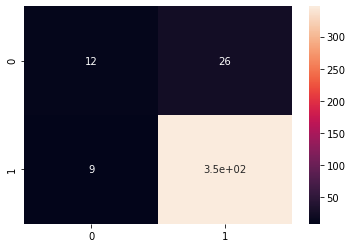

In [33]:
knn_matrix = confusion_matrix(y_test2, y_pred_knn)
sns.heatmap(knn_matrix, annot=True);

In [34]:
#Gridsearch commented out, best params are used in knn2 model

knn_params = {'n_neighbors':[3, 5, 7, 9, 11], 'metric': ['euclidian', 'manhattan', 'minkowski']}

knn_grid = GridSearchCV(estimator=knn, param_grid=knn_params)
knn_grid.fit(X_train2_scaled, y_train2)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidian', 'manhattan', 'minkowski'],
                         'n_neighbors': [3, 5, 7, 9, 11]})

In [35]:
knn_grid.best_params_

{'metric': 'minkowski', 'n_neighbors': 9}

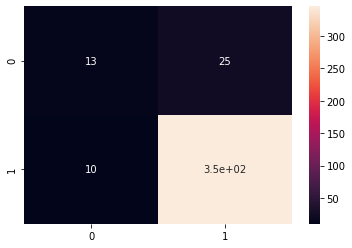

In [36]:
knn2 = KNeighborsClassifier(n_neighbors=9)

knn2.fit(X_train2_scaled, y_train2)
knn_pred2 = knn2.predict(X_test2_scaled)
knn_matrix2 = confusion_matrix(y_test2, knn_pred2)
sns.heatmap(knn_matrix2, annot=True);

In [37]:
metrics_crossval_score(knn2, X_train2_scaled, X_test2_scaled, y_train2, y_test2, knn_pred2)

(('Training set score:', 0.9270669992872417),
 ('Test set score:', 0.9010710808179162),
 ('Accuracy:', 0.9111675126903553),
 ('F1 score:', 0.9518569463548832),
 ('Precision:', 0.9326145552560647))

### Insight: while this model doesn't predict well, it is well fit to the data for both train and test. can we optimize further?

## GradientBoostingClassifier modeling

<AxesSubplot:>

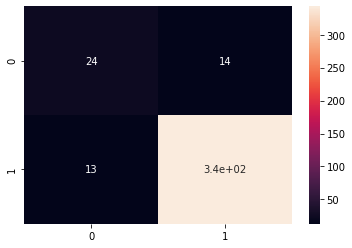

In [38]:
#XGBoost attempt and plot confusion matrix



GBC = GradientBoostingClassifier()
GBC.fit(X_train2_scaled, y_train2)
gbc_pred = GBC.predict(X_test2_scaled)
plot_matrix(y_test2, gbc_pred);

In [39]:
#crossval score and metrics for GB model
metrics_crossval_score(GBC, X_train2_scaled, X_test2_scaled, y_train2, y_test2, gbc_pred)

(('Training set score:', 0.9270848182466145),
 ('Test set score:', 0.9010386238234339),
 ('Accuracy:', 0.9314720812182741),
 ('F1 score:', 0.9621318373071528),
 ('Precision:', 0.9607843137254902))

### Insight: GB classifier works better than previous models. Can gridsearch optimize further?

In [40]:
#gridsearch is commented out due to extended runtime(> 1hr). The optimized parameters are used in the GBC2 model

# gbc_params = {'loss':['deviance', 'exponential'], 'learning_rate':[0.01, 0.1, 0.5, 1.0], 
#             'n_estimators':[100, 1000, 5000, 10000]}

# gbc_grid = GridSearchCV(estimator=GBC, param_grid=gbc_params)
# gbc_grid.fit(X_train2_scaled, y_train2)

In [41]:
# gbc_grid.best_params_

<AxesSubplot:>

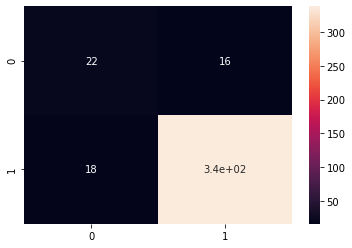

In [42]:
#Gradient booster classifier with best gridsearch params

GBC2 = GradientBoostingClassifier(loss='exponential', learning_rate=1.0, n_estimators=10000)
GBC2.fit(X_train2_scaled, y_train2)
gbc2_pred = GBC2.predict(X_test2_scaled)
plot_matrix(y_test2, gbc2_pred);

In [43]:
metrics_crossval_score(GBC2, X_train2_scaled, X_test2_scaled, y_train2, y_test2, gbc2_pred)

(('Training set score:', 0.9292765502494655),
 ('Test set score:', 0.8832846478416098),
 ('Accuracy:', 0.9137055837563451),
 ('F1 score:', 0.9521126760563381),
 ('Precision:', 0.9548022598870056))

### Insight: Paradoxically, the optimized parameters actually result in a WORSE model.

#### removing characters from feature names for XGBoost classifier

In [44]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_train2.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train2.columns.values]

In [45]:
X_test2.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test2.columns.values]

In [46]:
mapper = {'x0_(59,74]':'Age_59-74' ,'x0_(74,90]':'Age_74-90' , 'x0_[18,59]':'Age_18-59'}

X_train2_mod = X_train2.rename(mapper=mapper, axis=1)
X_test2_mod = X_test2.rename(mapper=mapper, axis=1)

<AxesSubplot:>

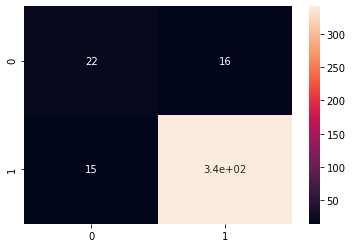

In [47]:
#attempting XGBoost classifier


xgb = XGBClassifier()

xgb.fit(X_train2, y_train2)
xgb_pred = xgb.predict(X_test2)
plot_matrix(y_test2, xgb_pred)

In [48]:
metrics_crossval_score(xgb, X_train2, X_test2, y_train2, y_test2, xgb_pred)

(('Training set score:', 0.9238239486813971),
 ('Test set score:', 0.9036027263875365),
 ('Accuracy:', 0.9213197969543148),
 ('F1 score:', 0.9565217391304349),
 ('Precision:', 0.9551820728291317))

In [49]:
#XGBoost classifier with SMOTE training values
x_train_smote.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in x_train_smote.columns.values]
X_test2.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test2.columns.values]

xgb2 = XGBClassifier()
xgb2.fit(x_train_smote, y_train_smote)
xgb2_pred = xgb2.predict(X_test2)
plot_matrix(y_test2, xgb2_pred)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'